## 简单的图分类任务
在本教程中，我们将学习如何使用 DGL 执行图分类，这个例子的任务目标就是对下面显示的八种拓扑类型Grpah进行分类。
![](https://data.dgl.ai/tutorial/batch/dataset_overview.png)

这里我们直接使用 DGL 中合成数据集 `data.MiniGCDataset`。数据集有八种不同类型的图，每个类都有相同数量的图样本

Using backend: pytorch


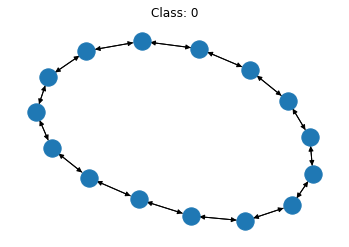

In [1]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

 创建graph的批数据

![](https://data.dgl.ai/tutorial/batch/batch.png)

In [6]:
import dgl
import torch

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels,dtype=torch.long)

构建Graph分类器 

![](https://data.dgl.ai/tutorial/batch/graph_classifier.png)

In [7]:
from dgl.nn.pytorch import GraphConv
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

In [8]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

# Create model
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 2.0010
Epoch 1, loss 1.9744
Epoch 2, loss 1.9551
Epoch 3, loss 1.9444
Epoch 4, loss 1.9318
Epoch 5, loss 1.9170
Epoch 6, loss 1.8928
Epoch 7, loss 1.8573
Epoch 8, loss 1.8212
Epoch 9, loss 1.7715
Epoch 10, loss 1.7152
Epoch 11, loss 1.6570
Epoch 12, loss 1.5885
Epoch 13, loss 1.5308
Epoch 14, loss 1.4719
Epoch 15, loss 1.4158
Epoch 16, loss 1.3515
Epoch 17, loss 1.2963
Epoch 18, loss 1.2417
Epoch 19, loss 1.1978
Epoch 20, loss 1.1698
Epoch 21, loss 1.1086
Epoch 22, loss 1.0780
Epoch 23, loss 1.0459
Epoch 24, loss 1.0192
Epoch 25, loss 1.0017
Epoch 26, loss 1.0297
Epoch 27, loss 0.9784
Epoch 28, loss 0.9486
Epoch 29, loss 0.9327
Epoch 30, loss 0.9133
Epoch 31, loss 0.9265
Epoch 32, loss 0.9177
Epoch 33, loss 0.9303
Epoch 34, loss 0.8666
Epoch 35, loss 0.8639
Epoch 36, loss 0.8474
Epoch 37, loss 0.8858
Epoch 38, loss 0.8393
Epoch 39, loss 0.8306
Epoch 40, loss 0.8204
Epoch 41, loss 0.8057
Epoch 42, loss 0.7998
Epoch 43, loss 0.7909
Epoch 44, loss 0.7840
Epoch 45, loss 0.780

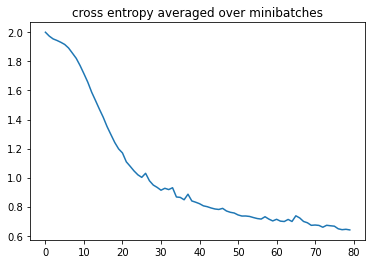

In [9]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

In [10]:
model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 58.7500%
Accuracy of argmax predictions on the test set: 62.500000%
